In [254]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import mplcyberpunk

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import  RandomForestClassifier
from sklearn.metrics import recall_score, log_loss, make_scorer, roc_curve, roc_auc_score, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

import sys
sys.path.append("../")
from src import cleaner, model
from src.api_client import EventAPIClient

plt.style.use('cyberpunk')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


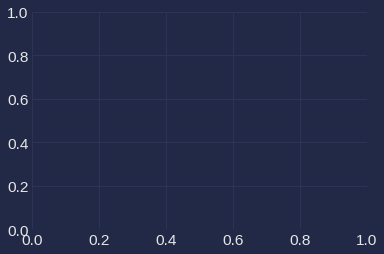

In [255]:
mplcyberpunk.add_glow_effects()
mplcyberpunk.add_underglow()
alpha_col = 0.7
colors = ["g", "deeppink", "dodgerblue", "orange", "white", "purple", "red"]

In [179]:
# Import data
data = pd.read_json('../data/data.json')

In [180]:
# Clean data and OHE columns
cleaned_data = cleaner.clean_with_target(data)
cleaned_data = cleaner.ohe_existence(cleaned_data, ['email_domain', 'payee_name'])

In [181]:
cleaned_data.head()

,channels,country,currency,delivery_method,fb_published,has_logo,listed,payout_type,user_created,user_type,venue_country,venue_latitude,venue_longitude,fraud,n_previous_payouts,event_duration,event_till_publish,user_event_lifespan,has_email_domain,has_payee_name
0,5,840,840,0.0,0,0,1,3,1259613950,1,840,25.777471,-80.133433,1,0,36000,370132.0,3125756,1,0
1,0,840,840,1.0,0,1,0,2,1280942776,3,840,32.776566,-79.930922,0,49,32400,625.0,12889894,1,1
2,8,840,840,1.0,0,0,1,2,1272559388,3,840,33.944201,-118.080419,0,36,27000,952.0,18531568,1,1
3,6,372,978,1.0,0,1,1,1,1283870102,3,-1,NaN,NaN,0,21,27831600,1876.0,76811468,1,0
4,11,840,840,0.0,1,0,1,2,1288984065,3,840,42.353848,-71.044276,0,49,28800,300.0,3010601,1,1


In [182]:
cleaned_data.to_csv('../data/cleaned_data.csv')

In [193]:
client = EventAPIClient()
new_data = client.get_data()
pd.DataFrame([new_data[0]])

,body_length,channels,country,currency,delivery_method,description,email_domain,event_created,event_end,event_published,...,user_age,user_created,user_type,venue_address,venue_country,venue_latitude,venue_longitude,venue_name,venue_state,sequence_number
0,6017,11,FR,EUR,1.0,"<p style=""margin-bottom: 1.4em; padding-bottom...",openstreetmap.fr,1359564847,1361757600,1.360496e+09,...,293,1334250959,4,86 boulevard Vivier Merle,FR,45.754934,4.858903,epitech,Rhone Alpes,2955


In [223]:
#print(pd.DataFrame(new_data))
cleaner.clean_row(new_data)

,channels,country,currency,delivery_method,fb_published,has_logo,listed,payout_type,user_created,user_type,venue_country,n_previous_payouts,event_duration,event_till_publish,user_event_lifespan,has_email_domain,has_payee_name
0,11,250,978,1.0,0,1,1,1,1334250959,4,250,0,120600,931021.0,25313888,1,0


In [224]:
df, proba_fraud, risk = model.predict_new_data(new_data, 'knn_model_v1')
df

Loading model from: ../models/knn_model_v1.pkl...


/home/maureen/anaconda3/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


ValueError: query data dimension must match training data dimension

# Set up Random Forest

In [136]:
def check_none(df):
    cols = df.columns
    for col in cols:
        print(col, (df[col] == 'None').sum())

In [121]:
# Limit columns for first round of modeling
to_keep = ['channels', 'country', 'currency', 'delivery_method', 'fb_published',
       'has_logo', 'listed', 'payout_type', 'user_created', 'user_type',
       'venue_country', 'n_previous_payouts', 'event_duration', 'fraud',
       'event_till_publish', 'user_event_lifespan', 'has_email_domain',
       'has_payee_name']
model_df = cleaned_data[to_keep]
model_df.info(), model_df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14337 entries, 0 to 14336
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   channels             14337 non-null  int64  
 1   country              14337 non-null  int64  
 2   currency             14337 non-null  int64  
 3   delivery_method      14321 non-null  float64
 4   fb_published         14337 non-null  int64  
 5   has_logo             14337 non-null  int64  
 6   listed               14337 non-null  int64  
 7   payout_type          14337 non-null  int64  
 8   user_created         14337 non-null  int64  
 9   user_type            14337 non-null  int64  
 10  venue_country        14337 non-null  int64  
 11  n_previous_payouts   14337 non-null  int64  
 12  event_duration       14337 non-null  int64  
 13  fraud                14337 non-null  int64  
 14  event_till_publish   14238 non-null  float64
 15  user_event_lifespan  14337 non-null 

(None,
 channels                0
 country                 0
 currency                0
 delivery_method        16
 fb_published            0
 has_logo                0
 listed                  0
 payout_type             0
 user_created            0
 user_type               0
 venue_country           0
 n_previous_payouts      0
 event_duration          0
 fraud                   0
 event_till_publish     99
 user_event_lifespan     0
 has_email_domain        0
 has_payee_name          0
 dtype: int64)

In [122]:
# Check to make sure no nan in dataframe
model_df = model_df.dropna()
model_df.isna().sum()

channels               0
country                0
currency               0
delivery_method        0
fb_published           0
has_logo               0
listed                 0
payout_type            0
user_created           0
user_type              0
venue_country          0
n_previous_payouts     0
event_duration         0
fraud                  0
event_till_publish     0
user_event_lifespan    0
has_email_domain       0
has_payee_name         0
dtype: int64

In [123]:
y = model_df.pop('fraud')
X = model_df.copy()

In [124]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [126]:
# Create model
model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)

# Predict and get scores
y_hat = model_rf.predict(X_test)
y_hat_proba = model_rf.predict_proba(X_test)
model_rf.score(X_test, y_test), recall_score(y_test, y_hat)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

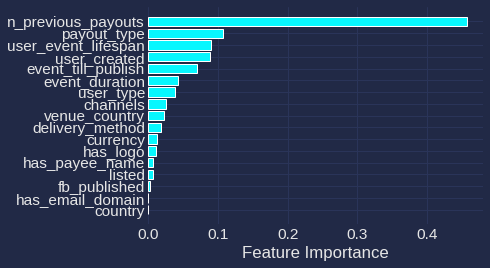

In [257]:
# Make plot of feature importances
importances = model_rf.feature_importances_
idx = np.argsort(importances)[::-1]
features = X_train.columns[idx]

# Change font size
import matplotlib
matplotlib.rc('font', size=10)
matplotlib.rc('axes', titlesize=10)

fig, ax = plt.subplots()
ax.barh(np.arange(len(features)), importances[idx][::-1])
ax.set_yticks(np.arange(len(features)))
ax.set_yticklabels(features[::-1])
ax.set_xlabel('Feature Importance')

plt.savefig('../images/feature_import_rf.png', bbox_inches='tight', dpi=250)

In [207]:
y_hat_proba[0], model_rf.classes_

(array([1., 0.]), array([0, 1], dtype=int64))

In [131]:
model_rf.predict_proba(np.array(X_test.iloc[10]).reshape(1,-1))

array([[1., 0.]])

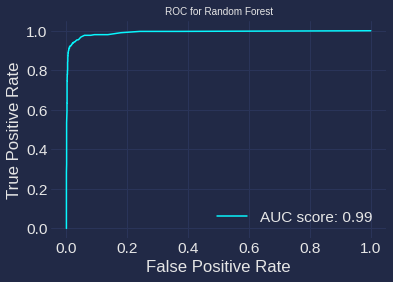

In [259]:
# ROC curve
auc = round(roc_auc_score(y_test, y_hat_proba[:,1]), 2)
fpr, tpr, thresh = roc_curve(y_test, y_hat_proba[:,1])
plt.plot(fpr, tpr, label=f'AUC score: {auc}')
plt.title('ROC for Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.savefig('../images/roc_rf.png', bbox_inches='tight', dpi=250)

Test Data Accuracy: 0.9848


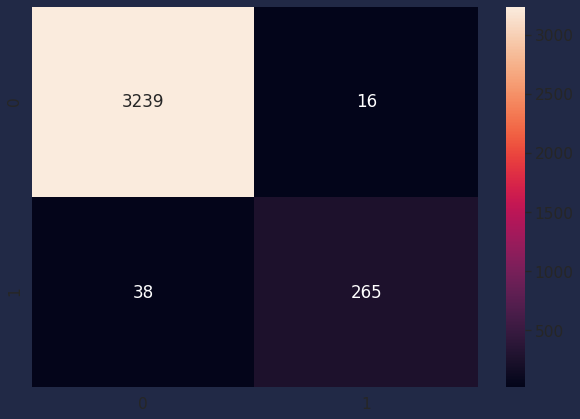

In [260]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_hat)

df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, fmt='g')
#plt.savefig('../images/confusion_rf.png', dpi=250)
print("Test Data Accuracy: %0.4f" % accuracy_score(y_test, y_hat))